In [1]:
import numpy as np
import pandas as pd
import math
%matplotlib inline
import statsmodels.api as sm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

plt.rcParams["font.size"] = 24
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

from IPython.core.pylabtools import figsize
figsize(15, 12)

import seaborn as sns

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [3]:
#importing the data and getting initial info
data = pd.read_csv("ml_vg_sales.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
System             16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


,Name,System,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data = data.rename(columns={"Year_of_Release": "Year", 
                            "NA_Sales": "NA",
                            "EU_Sales": "EU",
                            "JP_Sales": "JP",
                            "Other_Sales": "Other",
                            "Global_Sales": "Global"})
data["User_Score"] = data["User_Score"].replace("tbd", np.nan).astype(float)
data = data[data["Year"].notnull()]
data = data[data["Genre"].notnull()]
data["Year"] = data["Year"].apply(int)
data["Age"] = 2018 - data["Year"]
data.describe(include="all")

,Name,System,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Age
count,16448,16448,16448.000000,16448,16416,16448.000000,16448.000000,16448.000000,16448.000000,16448.00000,7983.000000,7983.000000,7463.000000,7463.000000,9907,9769,16448.000000
unique,11429,31,NaN,12,579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680,8,NaN
top,Need for Speed: Most Wanted,PS2,NaN,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ubisoft,E,NaN
freq,12,2127,NaN,3308,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201,3922,NaN
mean,NaN,NaN,2006.488996,NaN,NaN,0.263965,0.145895,0.078472,0.047583,0.53617,68.994363,26.441313,7.126330,163.015141,NaN,NaN,11.511004
std,NaN,NaN,5.877470,NaN,NaN,0.818286,0.506660,0.311064,0.187984,1.55846,13.920060,19.008136,1.499447,563.863327,NaN,NaN,5.877470
min,NaN,NaN,1980.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.01000,13.000000,3.000000,0.000000,4.000000,NaN,NaN,-2.000000
25%,NaN,NaN,2003.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.06000,60.000000,12.000000,6.400000,10.000000,NaN,NaN,8.000000
50%,NaN,NaN,2007.000000,NaN,NaN,0.080000,0.020000,0.000000,0.010000,0.17000,71.000000,22.000000,7.500000,24.000000,NaN,NaN,11.000000
75%,NaN,NaN,2010.000000,NaN,NaN,0.240000,0.110000,0.040000,0.030000,0.47000,79.000000,36.000000,8.200000,81.000000,NaN,NaN,15.000000


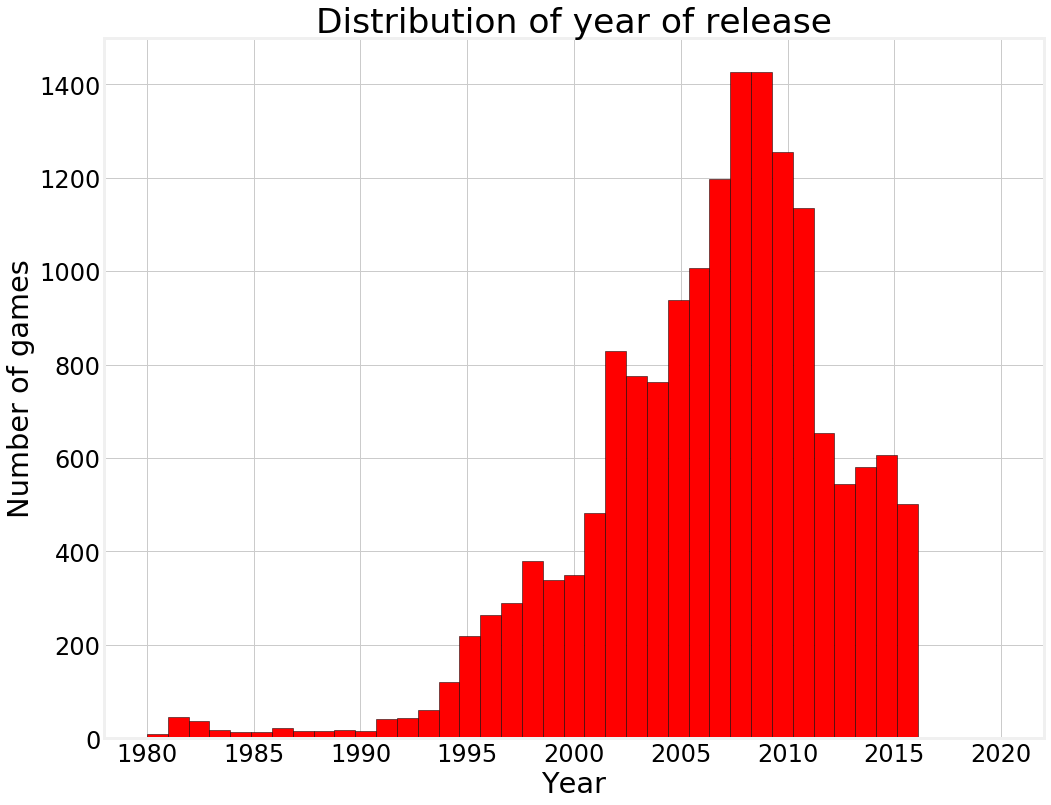

In [5]:
num_years = data["Year"].max() - data["Year"].min() + 1
plt.hist(data["Year"], bins=num_years, color="red", edgecolor="black")
plt.title("Distribution of year of release")
plt.xlabel("Year")
plt.ylabel("Number of games");

In [6]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : "Missing Values", 1 : "% of Total Values"})
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns


In [7]:
missing_values_table(data)

Your selected dataframe has 17 columns.
There are 17 columns that have missing values.


,Missing Values,% of Total Values
Name,0,0.000000
System,0,0.000000
Year,0,0.000000
Genre,0,0.000000
Publisher,32,0.194553
NA,0,0.000000
EU,0,0.000000
JP,0,0.000000
Other,0,0.000000
Global,0,0.000000


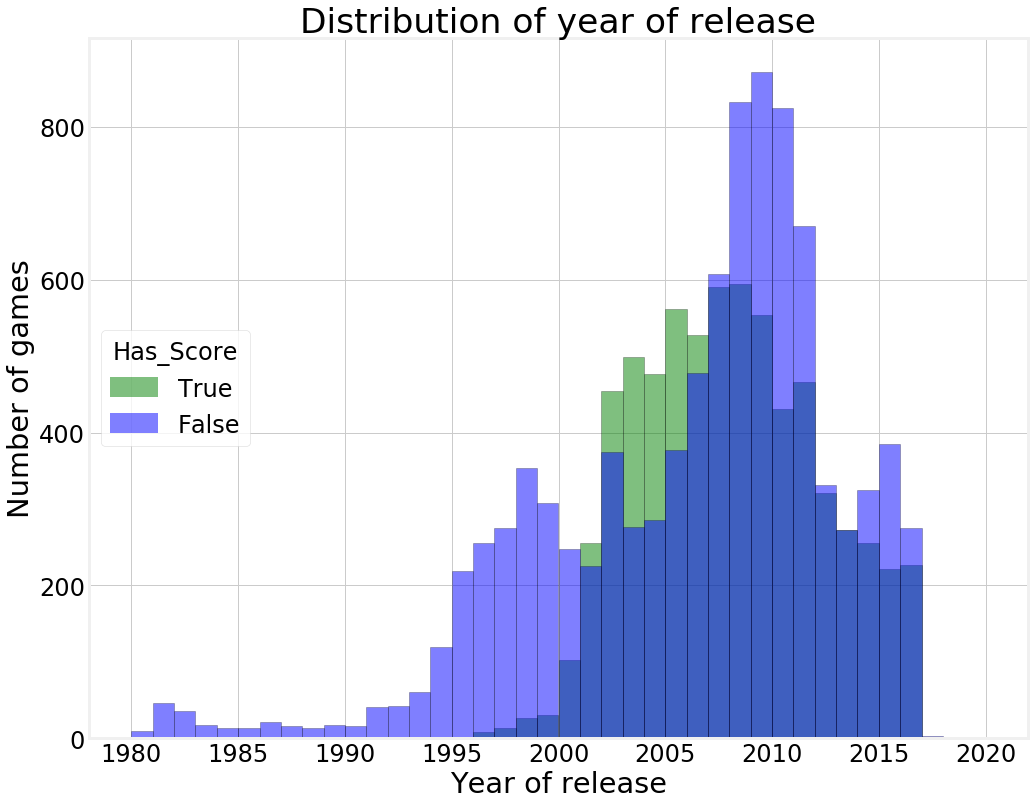

In [8]:
data["Has_Score"] = data["User_Score"].notnull() & data["Critic_Score"].notnull()
from matplotlib.lines import Line2D
plt.hist(data[data["Has_Score"]==True]["Year"], color="green", alpha=0.5, 
         bins=range(1980, 2021), edgecolor="black")
plt.hist(data[data["Has_Score"]==False]["Year"], color="blue", alpha=0.5, 
         bins=range(1980, 2021), edgecolor="black")
plt.title("Distribution of year of release")
plt.xlabel("Year of release")
plt.ylabel("Number of games")
plt.legend(handles=[Line2D([0], [0], color="green", lw=20, label="True", alpha=0.5),
                    Line2D([0], [0], color="blue", lw=20, label="False", alpha=0.5)],
           title="Has_Score", loc=6);

In [9]:
scored = data.dropna()
scored.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.394484,0.236089,0.064158,0.082677,0.777590,70.272088,28.931136,7.185626,174.722344,10.563223
std,4.211248,0.967385,0.687330,0.287570,0.269871,1.963443,13.868572,19.224165,1.439942,587.428538,4.211248
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.500000,4.000000,2.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,6.500000,11.000000,7.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,7.500000,27.000000,11.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,8.200000,89.000000,14.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,9.600000,10665.000000,33.000000


In [10]:
def donut_chart(column, palette="Set1"):
    values = column.value_counts().values
    labels = column.value_counts().index
    plt.pie(values, colors=sns.color_palette(palette), 
            labels=labels, autopct="%1.1f%%", 
            startangle=90, pctdistance=0.85)
    #draw circle
    centre_circle = plt.Circle((0,0), 0.70, fc="white")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

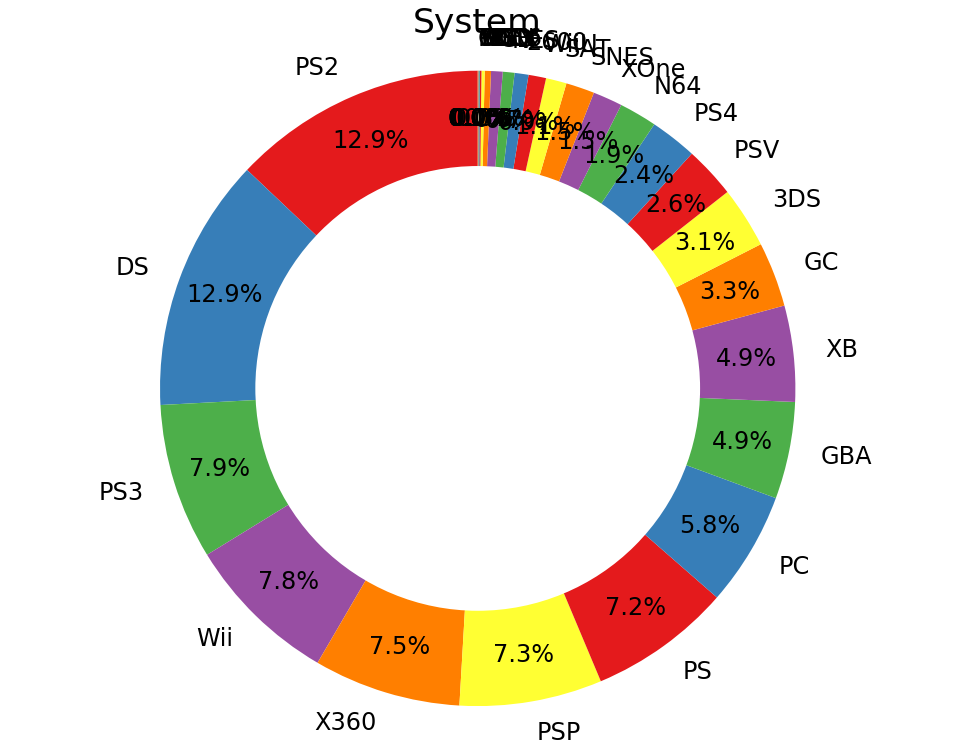

In [11]:
donut_chart(data["System"])
plt.title("System")
plt.axis("equal");

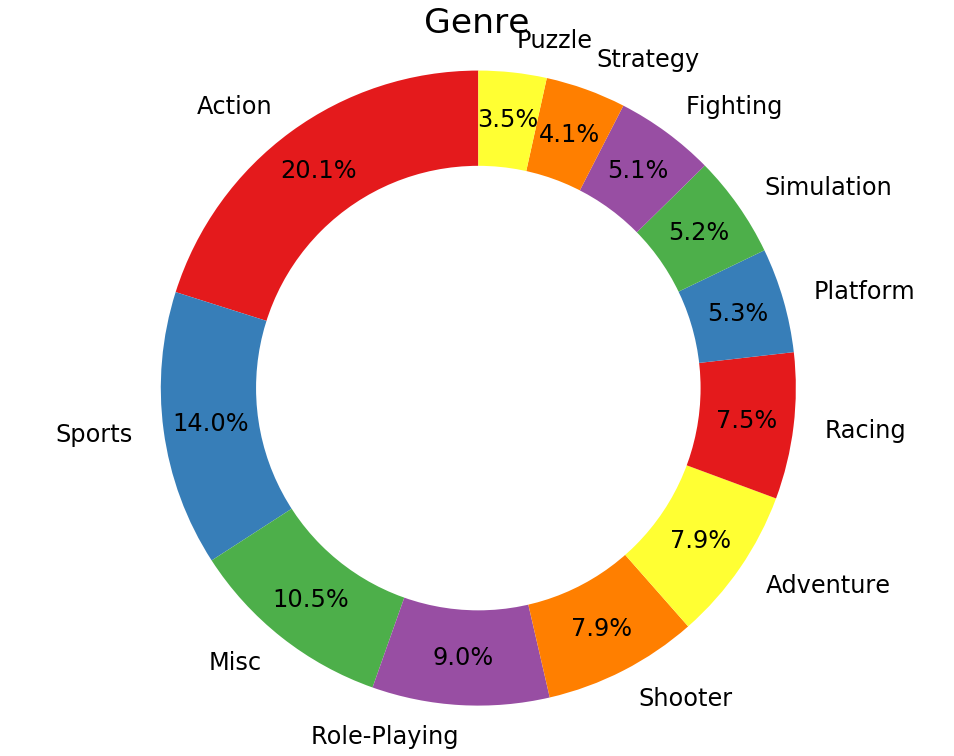

In [12]:
donut_chart(data["Genre"])
plt.title("Genre")
plt.axis("equal");

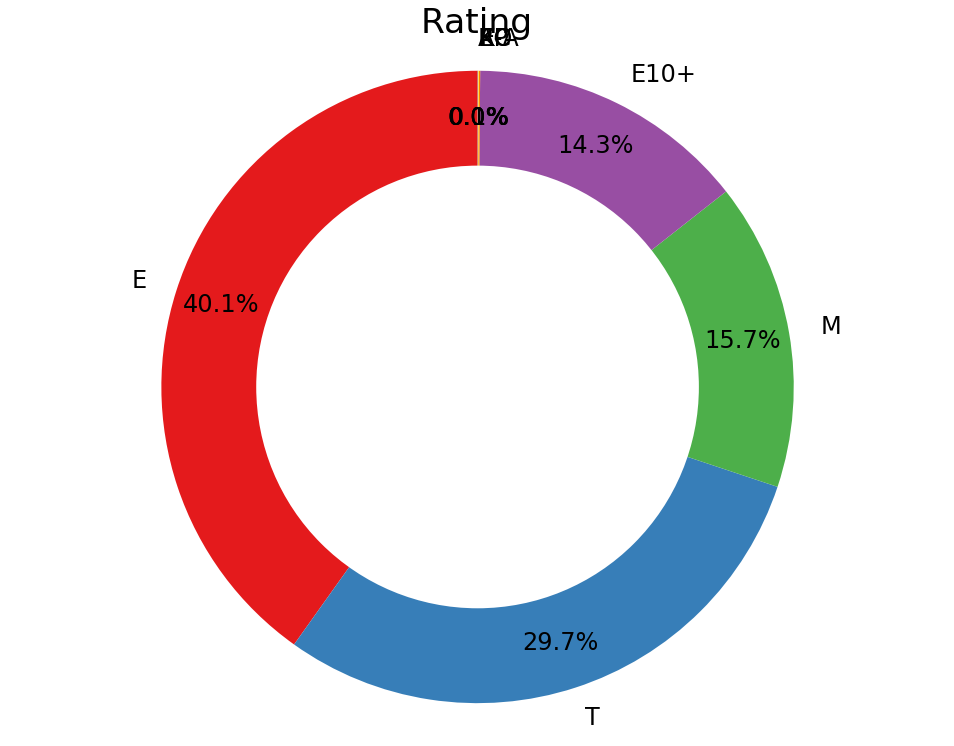

In [13]:
donut_chart(data["Rating"])
plt.title("Rating")
plt.axis("equal");

In [14]:
#making dummies for system
dummies1 = pd.get_dummies(scored['System'])
print(dummies1)
dummies2 = pd.get_dummies(scored['Genre'])
print(dummies2)
dummies3 = pd.get_dummies(scored['Rating'])
print(dummies3)

       3DS  DC  DS  GBA  GC  PC  PS  PS2  PS3  PS4  PSP  PSV  Wii  WiiU  X360  XB  XOne
0      0    0   0   0    0   0   0   0    0    0    0    0    1    0     0     0   0   
2      0    0   0   0    0   0   0   0    0    0    0    0    1    0     0     0   0   
3      0    0   0   0    0   0   0   0    0    0    0    0    1    0     0     0   0   
6      0    0   1   0    0   0   0   0    0    0    0    0    0    0     0     0   0   
7      0    0   0   0    0   0   0   0    0    0    0    0    1    0     0     0   0   
8      0    0   0   0    0   0   0   0    0    0    0    0    1    0     0     0   0   
11     0    0   1   0    0   0   0   0    0    0    0    0    0    0     0     0   0   
13     0    0   0   0    0   0   0   0    0    0    0    0    1    0     0     0   0   
14     0    0   0   0    0   0   0   0    0    0    0    0    0    0     1     0   0   
15     0    0   0   0    0   0   0   0    0    0    0    0    1    0     0     0   0   
16     0    0   0   0    0   0  

In [15]:
scored2 = scored.join(dummies1)
scored3 = scored2.join(dummies2)
scored4 = scored3.join(dummies3)

In [16]:
#######################################################################################################################
#Linear Regression

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [18]:
x = scored4[["Year", "Critic_Score", "Critic_Count", "User_Score", "User_Count", "Age", 
             "3DS" , "DC" , "DS" , "GBA" , "GC" , "PC" , "PS" , "PS2" , "PS3" , "PS4" , "PSP" , "PSV" , "Wii" , "WiiU" , 
             "XB" , "XOne",  
             'Action' , 'Adventure' , 'Fighting' , 'Misc' , 'Platform'  ,'Puzzle',  
             'Racing' , 'Role-Playing'  ,'Shooter' , 'Simulation' , 'Strategy', 
             "AO",  'E',  'E10+','K-A' , 'M' , 'RP']]
print(x.Year.dtype)
print(x.Critic_Score.dtype)
print(x.Critic_Count.dtype)
print(x.User_Score.dtype)
print(x.User_Count.dtype)
print(x.Age.dtype)

y = scored4["Global"]
x = x.as_matrix()
y = y.as_matrix()
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .25, random_state=0)


int64
float64
float64
float64
float64
int64


C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [19]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
x_train = sc.fit_transform(x_train)  
x_test = sc.transform(x_test)  

In [20]:
R = np.hstack((np.ones((len(x),1)), x))
results = sm.OLS(y, R).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     42.43
Date:                Wed, 19 Dec 2018   Prob (F-statistic):          5.78e-280
Time:                        02:03:09   Log-Likelihood:                -13561.
No. Observations:                6825   AIC:                         2.720e+04
Df Residuals:                    6786   BIC:                         2.747e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.829e-05   5.07e-06      3.608      0.0

In [21]:
################################################################################################################
#Machine Learning methods
#random forest

from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor

rf_mse_low = 10000000

for i in range(1,251,50):
    regressor = RandomForestRegressor(n_estimators= i, random_state=0)  
    regressor.fit(x_train, y_train)  
    y_pred = regressor.predict(x_test)
    if  metrics.mean_squared_error(y_test, y_pred) < rf_mse_low:
        rf_mse_low = metrics.mean_squared_error(y_test, y_pred)
        ind = i
print(ind)
 
regressor = RandomForestRegressor(n_estimators= ind, random_state=0)  
regressor.fit(x_train, y_train)  
y_pred = regressor.predict(x_test)
random_forest_mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', random_forest_mse)

201
Mean Squared Error: 2.295686179180636


In [22]:
#LASSO
import sklearn.linear_model as skl
import sklearn.feature_selection as skf

mld = skl.LassoCV()
mld.fit(x_train, y_train)

sfm = skf.SelectFromModel(mld, threshold=0.05)
sfm.fit(x_train, y_train)
where = sfm.get_support(indices=True)
sentence1 = "The relevant regressors are at positions: "
print(sentence1)
print(where)

The relevant regressors are at positions: 
[ 1  2  3  4  5  8 11 12 14 18 20 27 29 32 34]


In [29]:
from sklearn.metrics import mean_squared_error, r2_score
linreg = skl.LinearRegression()
linreg.fit(x_train, y_train)
co = np.array(linreg.coef_)
int = linreg.intercept_
params = np.insert(co, 0, int)
print('Coefficients: \n', linreg.coef_)
yhat_test = linreg.predict(x_test)
pre_lasso_mse = mean_squared_error(y_test, yhat_test)
print("Mean squared error:", pre_lasso_mse)


Coefficients: 
 [ 2.40806745e+02  3.04654699e-01  3.97766463e-01 -9.34748162e-02
  4.72267478e-01  2.40991353e+02  3.41013420e-02 -2.81868124e-02
  8.13907934e-02 -1.10252392e-02 -5.07928948e-02 -2.34153150e-01
  7.22444705e-02  5.42544984e-02  8.74193923e-02 -8.27776046e-04
  8.30326963e-03 -1.17615568e-03  2.54462384e-01  1.02406960e-02
 -1.20054899e-01  4.21802452e-02  3.60219491e-03 -4.10965334e-02
  6.84413772e-03  4.39365704e-02  1.87207462e-02 -7.71941633e-02
 -1.53146298e-02 -7.24651712e-02  3.40847691e-03  2.44361807e-02
 -6.45097990e-02 -1.07060394e+12  1.70577399e-01  3.07423879e-02
  2.61230314e-04  1.60742842e-02  0.00000000e+00]
Mean squared error: 6.71466197467776e+20


In [24]:
X = scored4[["Year", "Critic_Score", "Critic_Count", "User_Score", "User_Count",  
              "DC" , "GBA" , "GC" , "PC" , "PSV" ,   
              'Fighting' , 'Platform'  , 'Racing' , 'Simulation'  ]]

Y = scored4["Global"]
X = X.as_matrix()
Y = Y.as_matrix()
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = .25, random_state=0)

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  


C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [30]:
linreg2 = skl.LinearRegression()
linreg2.fit(X_train, Y_train)
co2 = np.array(linreg2.coef_)
int2 = linreg2.intercept_
params2 = np.insert(co2, 0, int2)
print('Coefficients: \n', linreg2.coef_)
Yhat_test = linreg2.predict(X_test)
post_lasso_mse = mean_squared_error(Y_test, Yhat_test)
print("Mean squared error:", post_lasso_mse)

Coefficients: 
 [-0.13149309  0.32149107  0.30674779 -0.11257233  0.47966864 -0.04171274
 -0.02429953 -0.07287903 -0.33353272 -0.04510618 -0.00825013  0.06574476
  0.0120356   0.04477592]
Mean squared error: 3.1670959026477763


In [26]:
R2 = np.hstack((np.ones((len(X),1)), X))
results = sm.OLS(Y, R2).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     91.90
Date:                Wed, 19 Dec 2018   Prob (F-statistic):          4.41e-243
Time:                        02:03:45   Log-Likelihood:                -13698.
No. Observations:                6825   AIC:                         2.743e+04
Df Residuals:                    6810   BIC:                         2.753e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.5982     12.075      5.433      0.0

In [27]:
scored4.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age,3DS,DC,DS,GBA,GC,PC,PS,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,AO,E,E10+,K-A,M,RP,T
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.394484,0.236089,0.064158,0.082677,0.777590,70.272088,28.931136,7.185626,174.722344,10.563223,0.022711,0.002051,0.067985,0.034725,0.050989,0.095385,0.021978,0.167033,0.112674,0.035018,0.057143,0.017289,0.070183,0.013040,0.125714,0.082784,0.023297,0.238828,0.036337,0.055385,0.056264,0.059048,0.017289,0.085128,0.104322,0.126593,0.043516,0.138168,0.039121,0.000147,0.305055,0.136264,0.000147,0.209963,0.000147,0.348278
std,4.211248,0.967385,0.687330,0.287570,0.269871,1.963443,13.868572,19.224165,1.439942,587.428538,4.211248,0.148990,0.045248,0.251739,0.183097,0.219991,0.293767,0.146622,0.373033,0.316217,0.183840,0.232132,0.130357,0.255474,0.113455,0.331551,0.275575,0.150855,0.426399,0.187141,0.228746,0.230447,0.235731,0.130357,0.279093,0.305701,0.332541,0.204032,0.345102,0.193897,0.012105,0.460464,0.343094,0.012105,0.407312,0.012105,0.476460
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.500000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,6.500000,11.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,7.500000,27.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,8.200000,89.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,9.600000,10665.000000,33.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
